### Import libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

#### Import components of statsmodels library

In [2]:
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


### Load the dataset

In [3]:
df_ts = pd.read_csv("uspopulation.csv", parse_dates=["DATE"], index_col='DATE')

In [4]:
df_ts.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


In [5]:
df_ts.tail(n=10)

,PopEst
DATE,
2018-03-01,326812
2018-04-01,326968
2018-05-01,327134
2018-06-01,327312
2018-07-01,327502
2018-08-01,327698
2018-09-01,327893
2018-10-01,328077
2018-11-01,328241


In [6]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 2011-01-01 to 2018-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PopEst  96 non-null     int64
dtypes: int64(1)
memory usage: 1.5 KB


#### Understanding the time frequency

In [7]:
df_ts.shape

(96, 1)

In [8]:
df_ts.columns

Index(['PopEst'], dtype='object')

In [9]:
df_ts.describe()

,PopEst
count,96.000000
mean,319826.760417
std,5159.523729
min,311037.000000
25%,315419.000000
50%,319919.500000
75%,324395.250000
max,328393.000000


In [10]:
df_ts.index.to_series().diff().value_counts()

DATE
31 days    55
30 days    32
28 days     6
29 days     2
Name: count, dtype: int64

In [11]:
print(df_ts.isna().sum())

PopEst    0
dtype: int64


In [12]:
### Check for duplicates values

df = df_ts[~df_ts.index.duplicated(keep='first')]

### Handle outliers

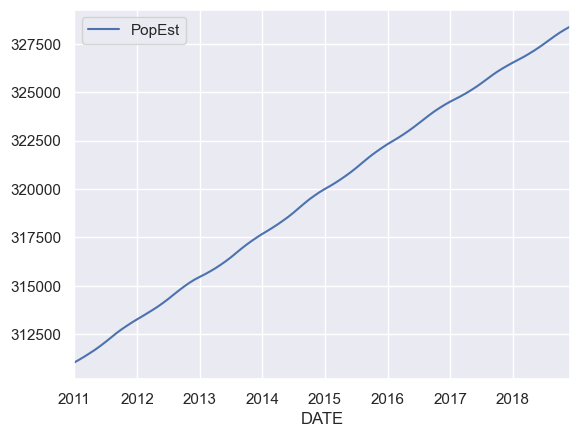

In [13]:
df.plot()
plt.show()

In [14]:
### Remove outliers
from scipy import stats
df['zscore'] = stats.zscore(df['PopEst'])
df_mod = df[df['zscore'].abs() < 3]

In [15]:
df_mod.head()

,PopEst,zscore
DATE,,
2011-01-01,311037,-1.712542
2011-02-01,311189,-1.682927
2011-03-01,311351,-1.651364
2011-04-01,311522,-1.618048
2011-05-01,311699,-1.583562


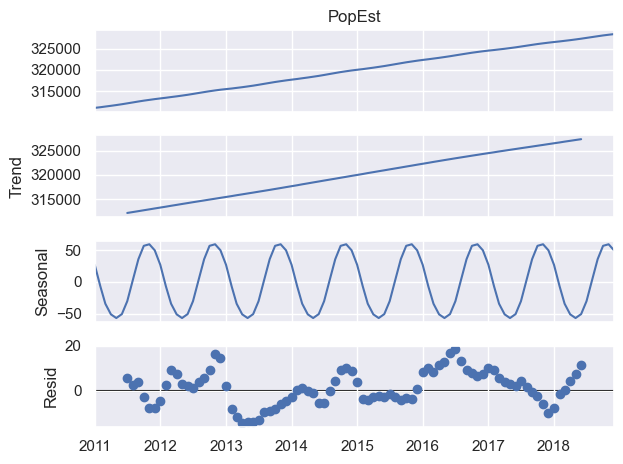

In [16]:

decomposition = seasonal_decompose(df_mod['PopEst'], model='additive')
decomposition.plot()
plt.show()


In [17]:
### Check the stationary of model
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name='Population estimation dataset'):
    result = adfuller(series.dropna())
    print(f"ADF test for {name}")
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("✅ Stationary (reject H0)")
    else:
        print("❌ Not stationary (fail to reject H0)")

In [18]:
adf_test(df_mod['PopEst'])  # original data
adf_test(df_mod['PopEst'].diff())  # first differencing
adf_test(df['PopEst'].diff(12))  # seasonal differencing

ADF test for Population estimation dataset
ADF Statistic: -1.392154706206933
p-value: 0.5860314182487191
Critical Values: {'1%': -3.5117123057187376, '5%': -2.8970475206326833, '10%': -2.5857126912469153}
❌ Not stationary (fail to reject H0)
ADF test for Population estimation dataset
ADF Statistic: -1.07254051376996
p-value: 0.7258973082379578
Critical Values: {'1%': -3.512738056978279, '5%': -2.8974898650628984, '10%': -2.585948732897085}
❌ Not stationary (fail to reject H0)
ADF test for Population estimation dataset
ADF Statistic: -1.2737428744265755
p-value: 0.6410977508891773
Critical Values: {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}
❌ Not stationary (fail to reject H0)


In [19]:
# Implement the log transform
df_mod_log = df_mod.copy()
df_mod_log['log_PopEst'] = np.log(df_mod_log['PopEst']).diff().dropna()

In [20]:
# Check newly the statinary of the 
adf_test(df_mod_log['log_PopEst'].diff().diff(12))  # original data
#adf_test(df_mod_log['log_PopEst'].diff())  # first differencing
#adf_test(df['PopEst'].diff(12))  # seasonal differencing

ADF test for Population estimation dataset
ADF Statistic: -4.567460899089078
p-value: 0.00014823315796815242
Critical Values: {'1%': -3.5274258688046647, '5%': -2.903810816326531, '10%': -2.5893204081632653}
✅ Stationary (reject H0)


In [21]:
sts.adfuller(df_mod['PopEst'])

(-1.392154706206933,
 0.5860314182487191,
 12,
 83,
 {'1%': -3.5117123057187376,
  '5%': -2.8970475206326833,
  '10%': -2.5857126912469153},
 489.04918195112333)

In [22]:
sts.adfuller(df_mod_log['log_PopEst'].diff().diff(12).dropna())

(-4.567460899089078,
 0.00014823315796815242,
 11,
 70,
 {'1%': -3.5274258688046647,
  '5%': -2.903810816326531,
  '10%': -2.5893204081632653},
 -1363.1685223929014)

### Plot PACF and ACF

In [23]:
df_mod['diff'] = df_mod['PopEst'].diff()

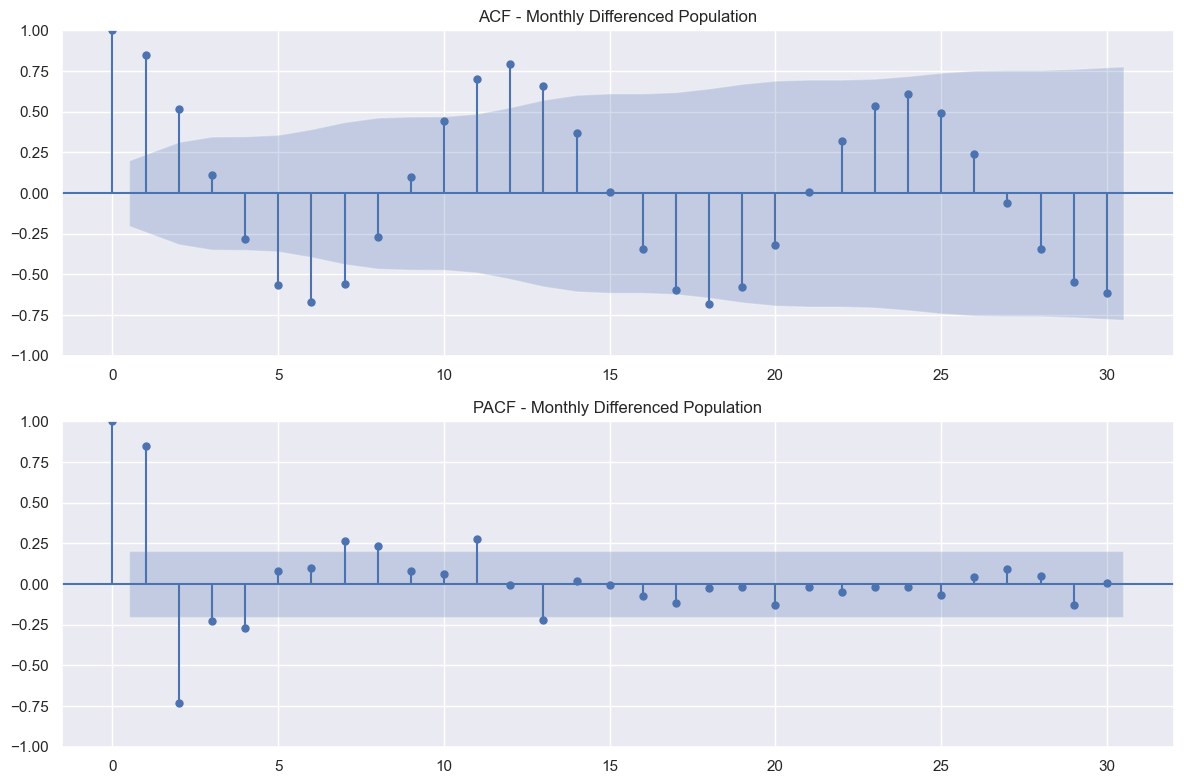

In [24]:
## Plot acf and pacf
## Based on: https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c/
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# ACF
plot_acf(df_mod['diff'].dropna(), ax=ax[0], lags=30)
ax[0].set_title("ACF - Monthly Differenced Population")

# PACF plot
plot_pacf(df_mod['diff'].dropna(), ax=ax[1], lags=30, method='ywm')
ax[1].set_title("PACF - Monthly Differenced Population")

plt.tight_layout()
plt.show()

### Defining the AR, I, MA terms

Based on the PACF plot, there is a significant spike at lag 2, which suggests the presence of a non-seasonal autoregressive term of order 2 (AR(2)). Additionally, a noticeable spike at the seasonal lag (e.g., lag 12) indicates the presence of a seasonal autoregressive term of order 1 (SAR(1)). This points to an AR(2) + SAR(1) structure for the autoregressive components.

On the other hand, the ACF plot shows a significant spike at lag 2, suggesting a non-seasonal moving average component of order 2 (MA(2)). Furthermore, a spike at the seasonal lag (lag 12) also indicates the need to include a seasonal moving average component of order 1 (SMA(1)). 

### ACF and PACF for the dataset with log and diff

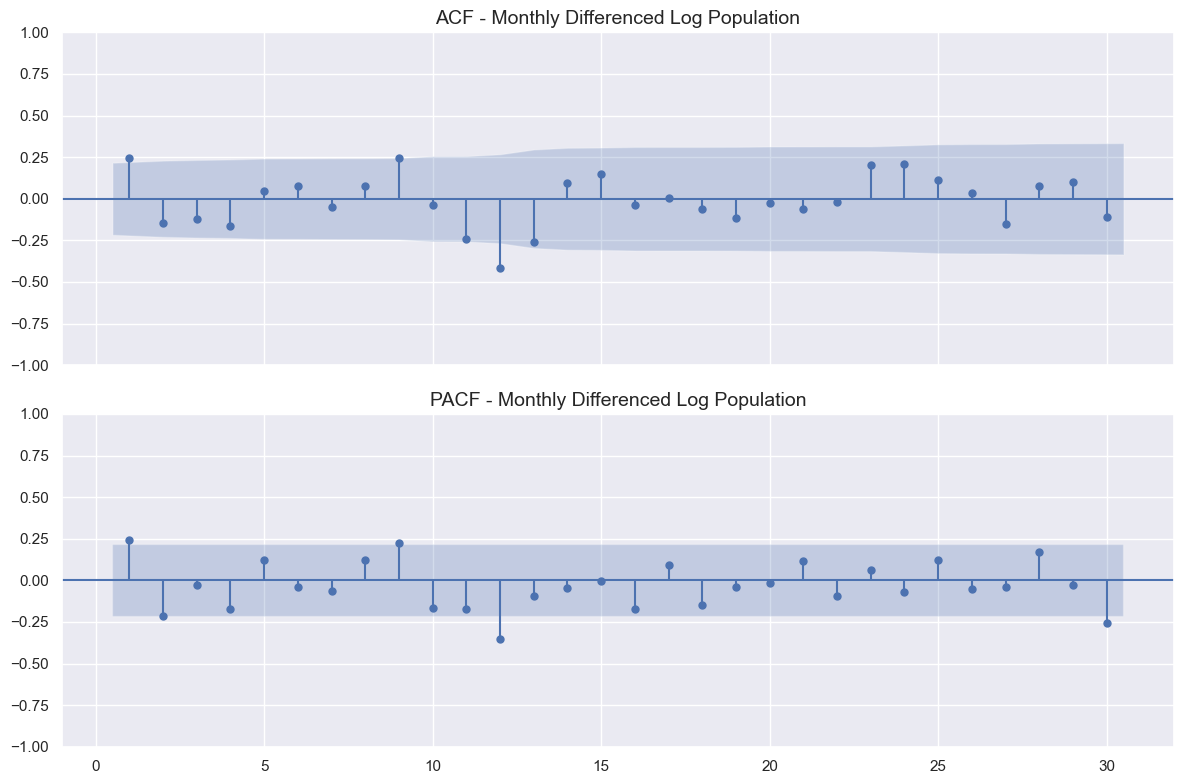

In [25]:
# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# ACF plot
sgt.plot_acf(
    df_mod_log['log_PopEst'].diff().diff(12).dropna(),
    ax=ax[0],
    zero=False,
    lags=30
)
ax[0].set_title("ACF - Monthly Differenced Log Population", fontsize=14)
ax[0].grid(True)


# PACF plot
sgt.plot_pacf(
    df_mod_log['log_PopEst'].diff().diff(12).dropna(),
    ax=ax[1],
    zero=False,
    lags=30,
    method='ywm'
)
ax[1].set_title("PACF - Monthly Differenced Log Population", fontsize=14)
ax[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

### SARIMA MODEL (0, 1, 0)(0, 1, 0)[12]

In [33]:
y_sarima = ARIMA(
    df_mod_log['log_PopEst'].diff().diff(12).dropna(),
    order=(0, 1, 0),
    seasonal_order=(0, 1, 0, 12)
)

c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [34]:
# Make the prediction
y_sarima_result = y_sarima.fit()

c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
y_sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                       log_PopEst   No. Observations:                   82
Model:             ARIMA(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 621.248
Date:                          Fri, 18 Apr 2025   AIC                          -1240.496
Time:                                  17:01:18   BIC                          -1238.262
Sample:                              03-01-2012   HQIC                         -1239.610
                                   - 12-01-2018                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.262e-10   3.51e-10      2.068      0.039    3.78e-11    1.41e-09
===================================================================================
Ljung-Box (L1) (Q):                   2.10   Jarque-Bera (JB):                 1.14
Prob(Q):                              0.15   Prob(JB):                         0.57
Heteroskedasticity (H):               0.62   Skew:                             0.00
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### AUTOARIMA 

In [38]:
from pmdarima import auto_arima

stepwise_model = auto_arima(
    df_mod['PopEst'].diff().dropna(),
    seasonal=True,
    m=12,            # seasonal period
    trace=True,
    max_p=3,
    max_q=3,
    max_P=2,
    max_Q=2,
    d=None,          
    D=None,
    start_P=0,
    start_Q=0,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was ren

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=631.390, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=877.172, Time=0.01 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1262.705, Time=0.00 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=596.280, Time=0.33 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=599.541, Time=0.69 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=598.626, Time=0.42 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=607.879, Time=0.31 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=0.75 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=579.449, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=663.122, Time=0.08 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=585.439, Time=0.55 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=585.500, Time=0.48 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=628.477, Time=0.19 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=0.78 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=652.702, Time=0.29 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.17 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=0.40 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.23 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=0.37 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=620.087, Time=0.33 sec


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,2)(1,0,0)[12]             : AIC=595.262, Time=0.15 sec

Best model:  ARIMA(1,0,2)(1,0,0)[12] intercept
Total fit time: 7.816 seconds


c:\Users\fSIoF\anaconda3\envs\timeseriesv2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
